In [1]:
!nvidia-smi

Mon Sep 27 15:48:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   68C    P2    75W / 250W |   1527MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 50%   

# Overview notebook

In [17]:
# some imports
import torch
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import os
import sys
sys.path.insert(0, '../')
from dataloader import KITTIloader, listflowfile
from modules.our_net import OurNet
from training.loss_functions import smoothL1, three_pixel_err
from my_utils import load_tune_checkpoint

In [3]:
# load data
device = 'cuda'

path_to_ray_results = '../../../ray_results/'

kitti_test_set = KITTIloader.KittiDataset('test')

kitti_val_set = KITTIloader.KittiDataset('val')

kitti_test = torch.utils.data.DataLoader(dataset=KITTIloader.KittiDataset('test'), 
                                                        batch_size=1, 
                                                        shuffle=True)

kitti_val = torch.utils.data.DataLoader(dataset=KITTIloader.KittiDataset('val'), 
                                                        batch_size=1, 
                                                        shuffle=True)

In [4]:
# Function to calculate loss and error on validation and test data
@torch.no_grad()
def evaluate_model(model, dataloader):
    loss_func = smoothL1(1.0)
    model.eval()
    
    losses = []
    errs = []
    
    for left, right, target in dataloader:
        left = left.to(device)
        right = right.to(device)
        target = target.to(device)
        prediction = model(left, right)
        losses.append(loss_func(target, prediction).item())
        errs.append(three_pixel_err(target, prediction).item())
            
    print('Smooth L1 loss: ', np.mean(losses))
    print('3 pixel error: ', np.mean(errs))

In [5]:
imagenet_stats = {'mean': np.array([0.485, 0.456, 0.406]),
                   'std': np.array([0.229, 0.224, 0.225])}

In [6]:
unnormalize = T.Normalize((-imagenet_stats['mean']/ imagenet_stats['std']).tolist(), (1.0 / imagenet_stats['std']).tolist())

In [32]:
# Function to show output of a model

#TODO
@torch.no_grad()
def show_output(model, dataloader=kitti_test, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=5, squeeze=False, figsize=(22,2.5*n))
    
    dataloader = iter(dataloader)
    
    #rng = np.random.default_rng()
    #img_indeces = rng.choice(len(dataloader), size=n, replace=False)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=192)
    
    for row in range(n):
        left, right, disp = next(dataloader) #[img_indeces[row]]
        left = left.to(device)
        right = right.to(device)
        disp = disp.to(device)
        
        pred = model(left, right)
        
        left = unnormalize(torch.squeeze(left, 0))
        right = unnormalize(torch.squeeze(right, 0))
        disp = torch.squeeze(disp, 0)
        pred = torch.squeeze(pred, 0)
        mask = (disp!=0.0)
        
        axs[row, 0].set(title='Original image left')
        axs[row, 1].set(title='Original image right')
        axs[row, 2].set(title='True disparity')
        axs[row, 3].set(title='Predicted disparity')
        axs[row, 4].set(title='Where disparity is not available\n(colored black)')
        
        for i in range(5):
            axs[row, i].title.set_size(10)
        
        to_numpy = lambda x: np.asarray(x.cpu())
        
        axs[row, 0].imshow(to_numpy(left.permute(1,2,0)))
        axs[row, 1].imshow(to_numpy(right.permute(1,2,0)))
        axs[row, 2].imshow(to_numpy(disp), norm=norm)
        axs[row, 3].imshow(to_numpy(pred), norm=norm)
        axs[row, 4].imshow(to_numpy(mask), cmap='gray', interpolation='nearest')
        print(mask.shape)
        print(mask.shape[0]*mask.shape[1])
        print((mask==0.0).sum().item()+(mask==1.0).sum().item())
    
    plt.tight_layout()
    cmap = mpl.cm.viridis
    
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='horizontal', label='disparity')


torch.Size([376, 1240])
466240
466240
torch.Size([376, 1240])
466240
466240


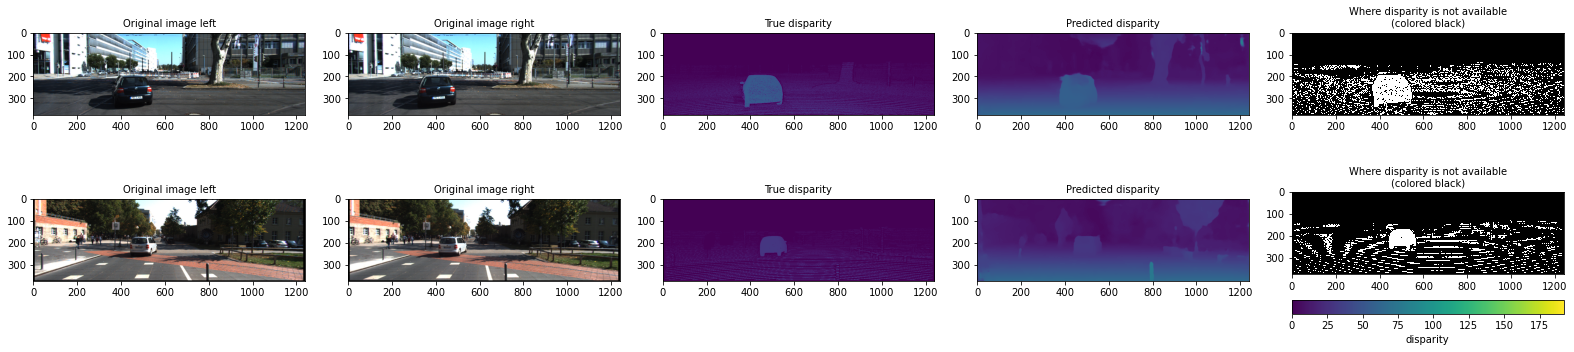

In [33]:
show_output(model, dataloader=kitti_test, n=2)

## Experiment 2

layers = {'feat': [3,16,32,64,128,256,32], 'cost': [64, 32, 32, 32, 32, 1]}

pretrain_path = os.path.join(path_to_ray_results,'experiment_2_finetune/train_3c540_00000_0_2021-09-13_11-30-29/checkpoint_000186/checkpoint')

# load the pretrained model
# (this is the finetuned model)
model = OurNet(channel_fe=layers['feat'], channel_cp=layers['cost'],
               dropout_p=0).to(device)
load_tune_checkpoint(model, pretrain_path)

The validation loss and error

evaluate_model(model, kitti_val)

The test loss and error

evaluate_model(model, kitti_test)

### Showing output

# TODO

## Experiment 3

In [8]:
layers = {'feat': [3,32,64,128,128,256,256,512,32], 'cost': [64,32,32,32,32,32,32,32,1]}

In [9]:
pretrain_path = os.path.join(path_to_ray_results, 'experiment_3_finetune/train_0ca00_00000_0_2021-09-11_16-53-39/checkpoint_000150/checkpoint')

In [10]:
# load the pretrained finetuned model
model = OurNet(channel_fe=layers['feat'], channel_cp=layers['cost'],
               dropout_p=0).to(device)
load_tune_checkpoint(model, pretrain_path)

The validation loss and error

In [ ]:
evaluate_model(model, kitti_val)

KeyboardInterrupt: 

The test loss and error

In [ ]:
evaluate_model(model, kitti_test)

#### Show outputs

/home/user/brank/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torchvision/transforms/functional.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))
/home/user/brank/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.w

torch.Size([376, 1240])
466240
tensor(87691, device='cuda:0')
tensor(378549, device='cuda:0')
torch.Size([376, 1240])
466240
tensor(90323, device='cuda:0')
tensor(375917, device='cuda:0')


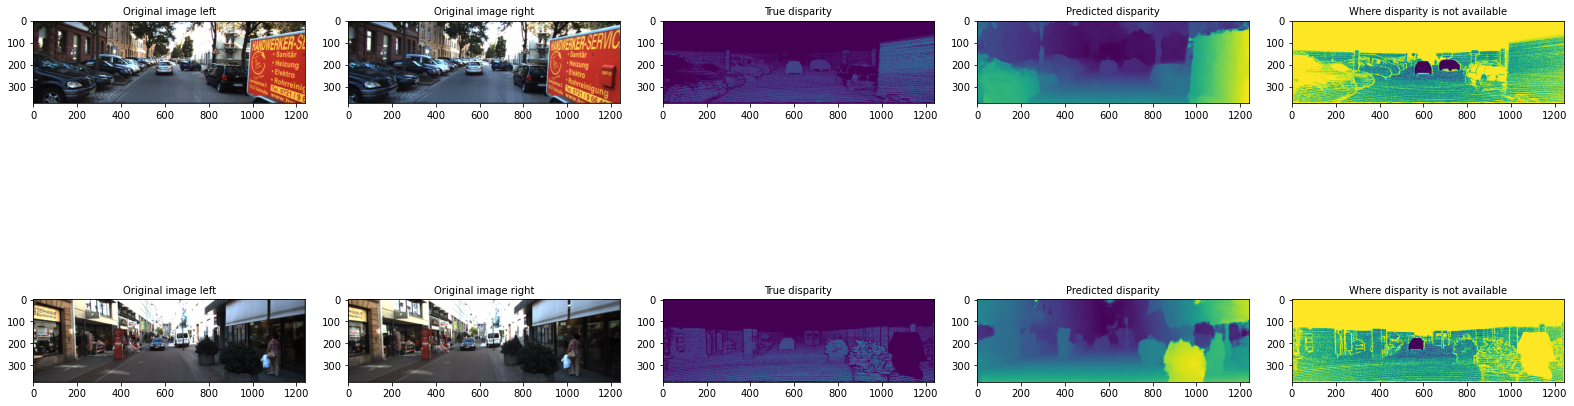

In [11]:
show_output(model, dataloader=kitti_test, n=2)

## Experiment 4 and 5